## 💡 Formulation logique d’une variante du TSP sur 5 États américains

On modélise un ensemble de contraintes logiques portant sur 5 États :

- `c` = California
- `t` = Texas
- `f` = Florida
- `n` = New York
- `i` = Illinois

---

### 🔢 Ensemble initial de 8 clauses (forme CNF)

Voici les contraintes du problème, formulées en logique propositionnelle :

1. `¬c ∨ ¬f`    # Si tu vas en Californie, tu ne vas pas en Floride
2. `¬n ∨ i`    # Si tu vas à New York, tu dois aussi aller en Illinois
3. `¬t ∨ ¬n`    # Si tu vas au Texas, tu ne vas pas à New York
4. `f ∨ ¬t`    # Si tu ne vas pas en Floride, tu ne vas pas au Texas
5. `¬i ∨ ¬c`    # Si tu vas en Illinois, tu ne peux pas aller en Californie
6. `¬f ∨ t`    # Si tu vas en Floride, tu dois aller au Texas
7. `¬c ∨ t`    # Si tu vas en Californie, tu dois aller au Texas
8. `¬n ∨ ¬f`    # Si tu vas à New York, tu ne vas pas en Floride

---

### ✅ Version simplifiée à 4 clauses

En appliquant des règles de simplification logique (absorption, équivalence, dominance), on obtient la version réduite suivante :

1. `¬f ∨ t`    # Si tu vas en Floride, tu dois aller au Texas
2. `¬i ∨ ¬c`    # Si tu vas en Illinois, tu ne peux pas aller en Californie
3. `¬n ∨ ¬f`    # Si tu vas à New York, tu ne vas pas en Floride
4. `¬n ∨ i`    # Si tu vas à New York, tu dois aussi aller en Illinois

---

Ces 4 clauses suffisent à **exprimer toutes les contraintes** du problème initial. Elles sont **logiquement équivalentes à l’ensemble complet des 8**, mais permettent une analyse plus rapide et plus efficace (par exemple avec l’algorithme de Grover).


In [266]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import XGate, ZGate
import sys
sys.path.append('./J-3/grover-team-2/Grover_Jupyter-Notebook')
from utils import get_disjunction_control_state, get_disjunction_qubits
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

QiskitRuntimeService.save_account(channel="ibm_quantum", token="19619dda4c21bed9d93987a1c7418ee5f18b7f43f18fc33db8eb472575ad75790054b5ec870cf0cc8e538fa6f054eca8b0ce4b5056c791a10b5efc51142c6f01", overwrite=True)

## Solution de base

In [267]:
clauses = []
# Si tu vas en Californie, tu ne vas pas en Floride
clauses.append({'x1' : False, 'x0' : False})
# Si tu vas à New York, tu dois aussi aller en Illinois
clauses.append({'x2' : False, 'x4' : True})
# Si tu vas au Texas, tu ne vas pas à New York
clauses.append({'x3' : False, 'x2' : False})
# Si tu ne vas pas en Floride, tu ne vas pas au Texas
clauses.append({'x1' : True, 'x3' : False})
# Si tu vas en Illinois, tu ne peux pas aller en Californie
clauses.append({'x4' : False, 'x0' : False})
# Si tu vas en Floride, tu dois aller au Texas
clauses.append({'x1' : False, 'x3' : False})
# Si tu vas en Californie, tu dois aller au Texas
clauses.append({'x0' : False, 'x3' : True})
clauses.append({'x4' : False})
# Si tu vas à New York, tu ne vas pas en Floride
clauses.append({'x2' : False, 'x1' : False})
clauses.append({'x1' : False, 'x0' : False, 'x3': True})    # ¬F ∨ ¬C ∨ T
clauses.append({'x2' : False, 'x4' : True, 'x1': False})    # ¬N ∨ I ∨ ¬F
clauses.append({'x3' : False, 'x2' : False, 'x0': True})    # ¬T ∨ ¬N ∨ C
clauses.append({'x1' : True, 'x3' : False, 'x4': False})    # F ∨ ¬T ∨ ¬I
clauses.append({'x4' : False, 'x0' : False, 'x1': True})    # ¬I ∨ ¬C ∨ F
clauses.append({'x1' : False, 'x3' : False, 'x2': True})    # ¬F ∨ T ∨ N
clauses.append({'x0' : False, 'x3' : True, 'x2': True})     # ¬C ∨ T ∨ N
clauses.append({'x2' : False, 'x1' : False, 'x0': False})   # ¬N ∨ ¬F ∨ ¬C


In [268]:
nb_variables = 5

In [269]:
# Transformer une disjonction en une porte
def logical_disjunction_to_gate(disj_clause):
    # Nombre de variables dans la clause
    nb_disj_variables = len(disj_clause)

    # Nombre de qubits dans la porte de disjonction (nb_variables + 1 qubit ancillaire)
    nb_qubits = nb_disj_variables + 1
    disj_qc = QuantumCircuit(nb_qubits)
    qubits = disj_qc.qubits

    # Obtenir le bon état de controle pour la porte multi-controle X
    ctrl_state = get_disjunction_control_state(disj_clause)

    # Créer une porte multi-controle X avec le bon nombre de qubits
    mc_xgate = XGate().control(num_ctrl_qubits=nb_disj_variables, ctrl_state = ctrl_state)
    disj_qc.append(mc_xgate, qubits)

    # Ajouter une porte X au qubit à la position -1 (dernière), le qubit ancillaire
    disj_qc.x(qubits[-1])

    # Transformer le circuit de disjonction en une porte avec un nom, mcx
    disj_gate = disj_qc.to_gate(label='mcx')
    return disj_gate

In [270]:
def circuit_clauses(clauses, var_qubits, clause_qubits):
    clauses_circuit =QuantumCircuit(var_qubits, clause_qubits)

    # Ajouter chaque clause de disjonction comme une porte :
    for i in range(len(clauses)):
        # Convertir la disjonction en porte
        gate = logical_disjunction_to_gate(clauses[i])
        # Sélectionner les qubits associés à la clause
        c_qubits = get_disjunction_qubits(clauses[i], clause_qubits[i], var_qubits)
        # Ajouter la porte au circuit de clauses
        clauses_circuit.append(gate, c_qubits)

    return clauses_circuit

In [271]:
def oracle(clauses_circuit):
    # Récupère les registres depuis clauses_circuit
    var_qubits = clauses_circuit.qregs[0]
    clause_qubits = clauses_circuit.qregs[1]

    # Crée un circuit oracle avec les mêmes registres
    oracle_circuit = QuantumCircuit(var_qubits, clause_qubits)

    # Appliquer le circuit de clauses
    oracle_circuit.append(clauses_circuit.to_gate(label='clauses_circuit'), clauses_circuit.qubits)

    ancilla = QuantumRegister(1, name="anc")
    oracle_circuit.add_register(ancilla)
    all_qubits = clause_qubits[:] + [ancilla[0]]
    mc_z_gate = ZGate().control(len(clause_qubits))
    oracle_circuit.append(mc_z_gate, all_qubits)

    # Appliquer l'inverse du circuit de clauses
    oracle_circuit.append(clauses_circuit.to_gate(label='clauses_circuit').inverse(), clauses_circuit.qubits)

    return oracle_circuit


In [272]:
 def diffuser():
    var_qubits = QuantumRegister(nb_variables, name='x')
    clause_qubits = QuantumRegister(len(clauses), name='c')
    # Construire le circuit de diffuseur
    diffuser_circuit = QuantumCircuit(var_qubits)

    # Ajouter des portes H et X pour chaque qubit du diffuseur
    ### 4 portes H pour les variables
    diffuser_circuit.h([0,1,2,3,4])
    ### 4 portes X pour les variables
    diffuser_circuit.x([0,1,2,3,4])
    # Ajouter une multi-controle Z
    mc_z_gate = ZGate().control(nb_variables - 1)
    diffuser_circuit.append(mc_z_gate, var_qubits)

    # Ajouter des portes X et H pour chaque qubit du diffuseur
    ### 4 portes X pour les variables
    diffuser_circuit.x([0,1,2,3,4])
    ### 4 portes H pour les variables
    diffuser_circuit.h([0,1,2,3,4])

    # Afficher le circuit
    diffuser_circuit.draw(output='mpl')
    return diffuser_circuit

In [273]:
def grover(clauses):
    var_qubits = QuantumRegister(nb_variables, name='x')
    clause_qubits = QuantumRegister(len(clauses), name='c')
    clauses_circuit = circuit_clauses(clauses, var_qubits, clause_qubits)
    oracle_circuit = oracle(clauses_circuit)
    diffuser_circuit = diffuser()
    # Construire le circuit de Grover
    c_bits = ClassicalRegister(nb_variables)
    grover_circuit = QuantumCircuit(var_qubits, clause_qubits, c_bits)

    # Ajouter des portes H pour chaque variable
    grover_circuit.h([0,1,2,3,4])

    # Identifier le nombre d'iterations
    nb_iterations = 5 # Jouez avec le nombre d'itérations pour en voir l'effet
    ancilla = QuantumRegister(1, name="anc")
    grover_circuit.add_register(ancilla)
    # Ajouter autant d'oracles et de diffuseurs qu'il y a de nombre d'itérations
    for it in range(nb_iterations):
        grover_circuit.append(oracle_circuit.to_gate(label='oracle'), grover_circuit.qubits)
        grover_circuit.barrier(grover_circuit.qubits)
        oracle_gate = oracle_circuit.to_gate(label='oracle')
        grover_circuit.append(oracle_circuit.to_gate(label='oracle'), var_qubits[:] + clause_qubits[:] + ancilla[:])


    # Ajouter les mesures pour l'evaluation du circuit
    grover_circuit.measure(var_qubits, c_bits)

    # Afficher le circuit
    return grover_circuit

In [274]:
def run_circuit(circ: QuantumCircuit):
    simulator = AerSimulator()

    # Transpilation pour le simulateur
    transpiled_circ = transpile(circ, simulator)

    # Exécution
    job = simulator.run(transpiled_circ, shots=3000)
    result = job.result()

    counts = result.get_counts()
    return counts

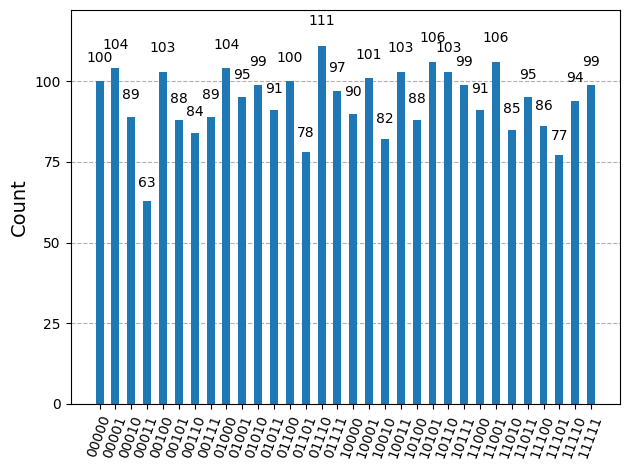

In [275]:
grover_circuit = grover(clauses)
counts = run_circuit(grover_circuit)
grover_circuit.decompose(gates_to_decompose=['oracle', 'clauses_circuit', 'diffusor', 'mcx'], reps=3).draw(output='mpl',scale=0.2)
plot_histogram(counts)

In [276]:
improved_clauses = []
improved_clauses.append({'x1' : False, 'x0' : False})
# Si tu vas à New York, tu dois aussi aller en Illinois
improved_clauses.append({'x2' : False, 'x4' : True})
# Si tu vas au Texas, tu ne vas pas à New York
improved_clauses.append({'x3' : False, 'x2' : False})
# Si tu ne vas pas en Floride, tu ne vas pas au Texas
improved_clauses.append({'x1' : True, 'x3' : False})
# Si tu vas en Illinois, tu ne peux pas aller en Californie
improved_clauses.append({'x4' : False, 'x0' : False})
# Si tu vas en Floride, tu dois aller au Texas
improved_clauses.append({'x1' : False, 'x3' : False})
# Si tu vas en Californie, tu dois aller au Texas
improved_clauses.append({'x0' : False, 'x3' : True})
# Si tu vas à New York, tu ne vas pas en Floride
improved_clauses.append({'x2' : False, 'x1' : False})
improved_clauses.append({'x4' : False})


{'00010': 88, '11100': 92, '10010': 88, '10111': 104, '00110': 81, '11000': 95, '11010': 88, '10001': 97, '01000': 101, '00001': 89, '10110': 89, '10101': 90, '11111': 83, '10100': 93, '11011': 95, '10011': 104, '01001': 94, '00111': 102, '01110': 99, '01111': 120, '11001': 92, '01010': 108, '11101': 99, '00011': 92, '00100': 92, '00000': 92, '01101': 100, '01011': 94, '01100': 85, '11110': 79, '00101': 91, '10000': 84}


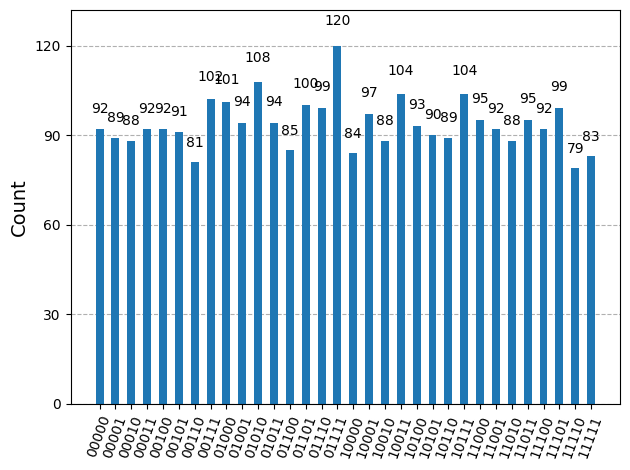

In [277]:
grover_circuit = grover(improved_clauses)
counts = run_circuit(grover_circuit)
print(counts)
plot_histogram(counts)